In [20]:
from __future__ import division, print_function, unicode_literals
import gym
import numpy as np
import os
import sys
import tensorflow as tf

# matplotlib 설정
from IPython.display import HTML
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [21]:
env = gym.make("MsPacman-v0")
obs = env.reset()
obs.shape

(210, 160, 3)

In [22]:
env.action_space

Discrete(9)

In [23]:
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # 자르고 크기를 줄입니다.
    img = img.sum(axis=2) # 흑백 스케일로 변환합니다.
    img[img==mspacman_color] = 0 # 대비를 높입니다.
    img = (img // 3 - 128).astype(np.int8) # -128~127 사이로 정규화합니다.
    return img.reshape(88, 80, 1)

img = preprocess_observation(obs)

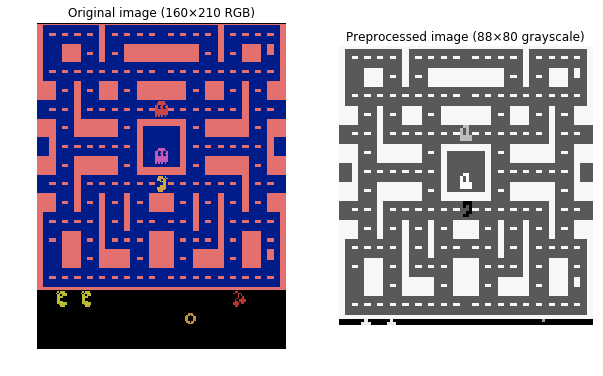

In [24]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.title("Original image (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed image (88×80 grayscale)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
plt.savefig("preprocessing_plot")
plt.show()

In [25]:
reset_graph()

input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3 
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10  # conv3은 11x10 크기의 64개의 맵을 가집니다
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n  # 9개의 행동이 가능합니다
initializer = tf.variance_scaling_initializer()

def q_network(X_state, name):
    prev_layer = X_state / 128.0 # 픽셀 강도를 [-1.0, 1.0] 범위로 스케일 변경합니다.
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

In [26]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                            input_channels])
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name])
            for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

In [27]:
online_vars

{'/conv2d/bias:0': <tf.Variable 'q_networks/online/conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 '/conv2d/kernel:0': <tf.Variable 'q_networks/online/conv2d/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>,
 '/conv2d_1/bias:0': <tf.Variable 'q_networks/online/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_1/kernel:0': <tf.Variable 'q_networks/online/conv2d_1/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>,
 '/conv2d_2/bias:0': <tf.Variable 'q_networks/online/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_2/kernel:0': <tf.Variable 'q_networks/online/conv2d_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 '/dense/bias:0': <tf.Variable 'q_networks/online/dense/bias:0' shape=(512,) dtype=float32_ref>,
 '/dense/kernel:0': <tf.Variable 'q_networks/online/dense/kernel:0' shape=(7040, 512) dtype=float32_ref>,
 '/dense_1/bias:0': <tf.Variable 'q_networks/online/dense_1/bias:0' shape=(9,) dtype=float32_ref>,
 '/dense_1/kernel:0': <tf.Variable 'q_networks/online/de

In [28]:
learning_rate = 0.001
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keep_dims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum,
                                           use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [29]:
class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) # 더 빠름
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]

In [30]:
replay_memory_size = 500000
replay_memory = ReplayMemory(replay_memory_size)

In [31]:
def sample_memories(batch_size):   
    cols = [[], [], [], [], []] # 상태, 행동, 보상, 다음 상태, 계속
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0],cols[1],cols[2].reshape(-1, 1),cols[3],cols[4].reshape(-1, 1)

In [32]:
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # exploration
    else:
        return np.argmax(q_values) # exploitation

In [33]:
n_steps = 4000000  # 전체 훈련 스텝 횟수
training_start = 10000  # 10,000번 게임을 반복한 후에 훈련 시작
training_interval = 4  # 4번 게임을 반복하고 훈련 스텝 실행
save_steps = 1000  # 1,000번 훈련 스텝마다 모델 저장
copy_steps = 10000  # 10,000번 훈련 스텝마다 Actual DQN을 Target DQN으로 복사
discount_factor = 0.99
skip_start = 90  # 게임의 시작 부분은 스킵
batch_size = 50
iteration = 0  # 게임 반복횟수
checkpoint_path = "./my_dqn.ckpt"
done = True # 환경 리셋의 필요 여부 판단

In [34]:
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

In [35]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print("\r반복 {}\t훈련 스텝 {}/{} ({:.1f})%\t손실 {:5f}\t평균 최대-Q {:5f}   ".format(
            iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q), end="")
        if done: # 게임이 종료되면 다시 시작합니다
            obs = env.reset()
            for skip in range(skip_start): # 게임 시작 부분은 스킵합니다
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)

        # Actual DQN이 해야할 Action을 평가합니다
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # Actual DQN으로 게임을 플레이합니다.
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)

        # Replay buffer에 기록합니다
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        # 트래킹을 위해 통계값을 계산합니다
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0

        if iteration < training_start or iteration % training_interval != 0:
            continue
        
        # Target DQN을 사용해서 메모리에서 샘플링하여 Target Q value를 구합니다
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_factor * max_next_q_values

        # Actual DQN을 학습시킵니다
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val, X_action: X_action_val, y: y_val})

        # Actual DQN을 Target DQN으로 정해둔 일정 간격마다 복사합니다
        if step % copy_steps == 0:
            copy_online_to_target.run()

        # 정해둔 일정 간격으로 저장합니다
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt
반복 853	훈련 스텝 18001/4000000 (0.5)%	손실   inf	평균 최대-Q 0.154167   

KeyboardInterrupt: 

In [36]:
frames = []
n_max_steps = 10000

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    obs = env.reset()
    for step in range(n_max_steps):
        state = preprocess_observation(obs)

        # Actual DQN이 해야할 Action을 평가합니다
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = np.argmax(q_values)

        # Actual DQN이 게임을 플레이합니다
        obs, reward, done, info = env.step(action)

        img = env.render(mode="rgb_array")
        frames.append(img)

        if done:
            break

INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt


In [38]:
env.get_keys_to_action()

{(): 0,
 (97,): 3,
 (97, 115): 8,
 (97, 119): 6,
 (100,): 2,
 (100, 115): 7,
 (100, 119): 5,
 (115,): 4,
 (119,): 1}

In [ ]:
def update_scene(num, frames, patch):
    plt.close()
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, figsize=(5,6), repeat=False, interval=40):
    fig = plt.figure(figsize=figsize)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), 
                                   frames=len(frames), repeat=repeat, interval=interval)

In [ ]:
video = plot_animation(frames, figsize=(5,6))
HTML(video.to_html5_video())  # HTML5 동영상으로 만들어 줍니다